In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import IPython.display as ipd  # To play sound in the notebook

In [2]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [3]:
df = pd.read_csv('Train.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')
df.shape, sample_sub.shape

((1109, 2), (1017, 194))

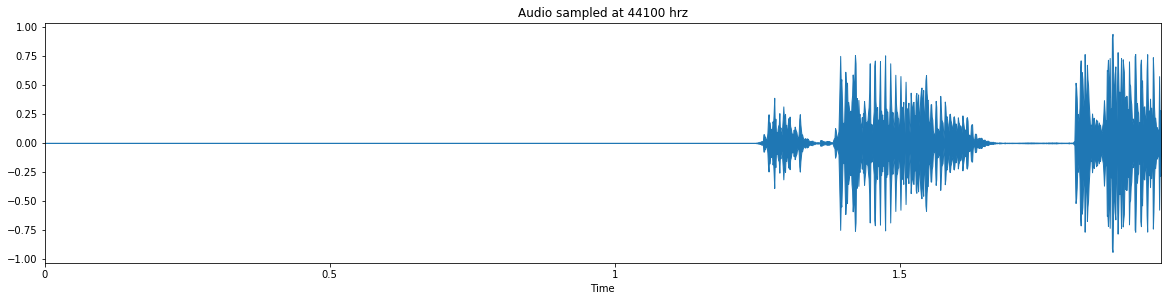

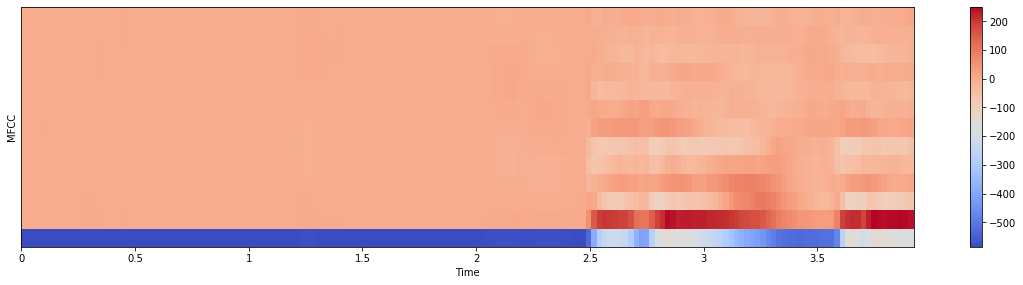

In [4]:
#Visualizing a few files and comparing their MFCCs

path = "audio_files/IV38R7F.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

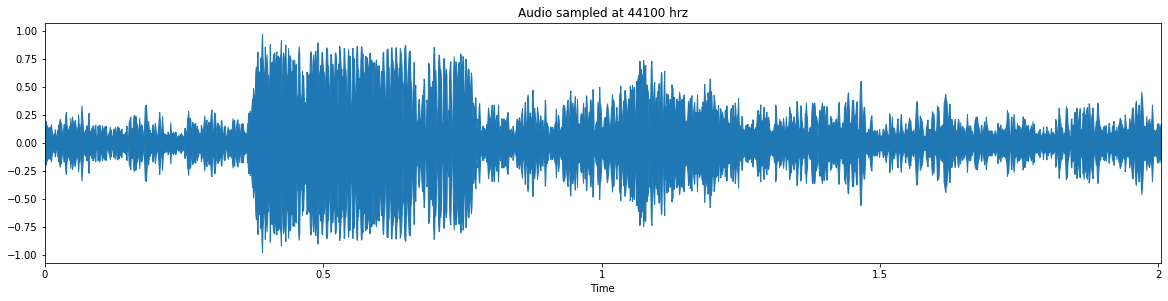

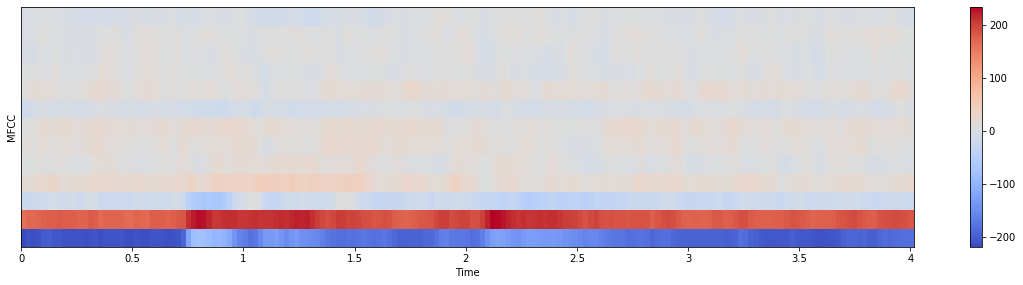

In [5]:
path = "audio_files/KM4SKWT.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

## Statistical features
Now we've seen the shape of an MFCC output for each file, and it's a 2D matrix format with MFCC bands on the y-axis and time on the x-axis, representing the MFCC bands over time. To simplify things, what we're going to do is take the mean across each band over time. In other words, row means. But how does it present as a distinctive feature?

So if you look at the above MFCC plot, the first band at the bottom is the most distinctive band over the other bands. Since the time window is a short one, the changes observed overtime does not vary greatly. The key feature is capturing the information contained in the various bands. Lets plot the mean of each of the band and display it as a time series plot to illustrate the point.


169
173


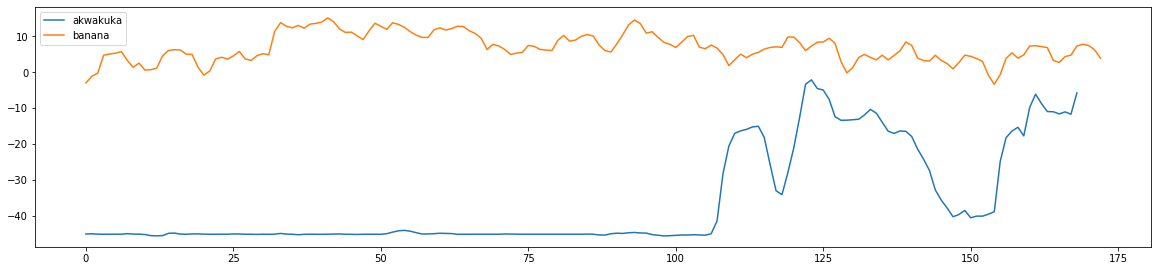

In [6]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "audio_files/IV38R7F.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2,offset=0.5)  
akwakuka = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
akwakuka = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(akwakuka))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "audio_files/KM4SKWT.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',sr=22050*2,offset=0.5)  
banana = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
banana = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(banana))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(akwakuka, label='akwakuka')
plt.plot(banana, label='banana')
plt.legend()

Notice the difference between the two audios. 'akwakuka' had a long silence at the beginning which we would deal with later. While 'banana' has a higher pith than the 'akwakuka', which may mean that a female pronounced the 'banana' audio.

### NOTE
Using MFCC is a good feature to differentiate the gender and emotions as demonstrated above. Even thou we've ommited alot of good information by just taking the mean, it seems we still capture enough to be able to see some difference. Whether this difference is significant for distinguishing the various classes, we'll find out in the next part where we will create a baseline e classifier



## Data preparation and processing


In [90]:
#HERE we now process our mfccs from the trainset audio files and save them in a dataframe dff

dff = pd.DataFrame(columns=['feature'])

counter=0

for file in df['fn']:
        
        X, sample_rate = librosa.load(file,res_type='kaiser_fast', duration=2.5, sr=44100)
        sample_rate = np.array(sample_rate)
        
        # mean as the feature. Could do min and max etc as well. 
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
        
        dff.loc[counter] = [mfccs]
        counter=counter+1   
        

# Check a few records to make sure its processed successfully
print(len(dff))
dff.head()

1109


,feature
0,"[-44.77324, -39.253258, -31.491854, -30.133383..."
1,"[-11.288435, -1.3717802, 2.7510173, 4.80323, 4..."
2,"[8.021849, 10.738857, 11.262934, 11.8402405, 1..."
3,"[-30.089832, -29.324013, -28.87491, -27.209444..."
4,"[-41.03587, -34.62066, -18.434624, -16.746412,..."


#### Data processing
Like any good standard data science workflow, data processing is the most important step. Cause garbage in grabage out. So lets start munging the data into a workable format and pad out any issues we find.

In [91]:
#Now lets extract the each mean band component of the mfccs into their different columns
dff = pd.concat([df,pd.DataFrame(dff['feature'].values.tolist())],axis=1)
dff[:5]

,fn,label,0,1,2,3,4,5,6,7,...,206,207,208,209,210,211,212,213,214,215
0,audio_files/IV38R7F.wav,akawuka,-44.773239,-39.253258,-31.491854,-30.133383,-33.960716,-35.793442,-33.051308,-34.015152,...,-10.956895,-10.863541,-11.556558,-11.044641,-11.525646,-6.099812,NaN,NaN,NaN,NaN
1,audio_files/KM4SKWT.wav,banana,-11.288435,-1.371780,2.751017,4.803230,4.790741,1.651309,-0.412495,0.585379,...,6.969593,3.526595,2.636493,4.278601,4.706738,7.144873,7.782613,7.493994,6.322552,3.820127
2,audio_files/F5POSU9.wav,obulwadde,8.021849,10.738857,11.262934,11.840240,10.762719,6.276207,4.340938,2.413251,...,7.070533,7.846087,7.603508,8.561801,10.041899,8.293550,5.717575,5.289046,7.331453,8.375529
3,audio_files/MMVDXG2.wav,nnyaanya,-30.089832,-29.324013,-28.874910,-27.209444,-24.818371,-24.910892,-26.006748,-25.727741,...,-4.159011,-4.322663,-4.408619,-4.831316,-4.881852,-2.832334,NaN,NaN,NaN,NaN
4,audio_files/9TVM96F.wav,pampu,-41.035870,-34.620659,-18.434624,-16.746412,-24.933903,-29.880964,-29.128811,-31.251930,...,-26.394936,-28.571432,-31.340599,-29.104830,-29.183437,-30.648743,-34.224022,-35.549515,-26.576780,-17.687740


In [59]:
# replace NA with 0
dff=dff.fillna(0)
print(dff.shape)
dff[:5]

(1109, 240)


,fn,label,0,1,2,3,4,5,6,7,...,228,229,230,231,232,233,234,235,236,237
0,audio_files/IV38R7F.wav,akawuka,-44.773239,-39.253258,-31.491854,-30.133383,-33.960716,-35.793442,-33.051308,-34.015152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,audio_files/KM4SKWT.wav,banana,-11.288435,-1.371780,2.751017,4.803230,4.790741,1.651309,-0.412495,0.585379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,audio_files/F5POSU9.wav,obulwadde,8.021849,10.738857,11.262934,11.840240,10.762719,6.276207,4.340938,2.413251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,audio_files/MMVDXG2.wav,nnyaanya,-30.089832,-29.324013,-28.874910,-27.209444,-24.818371,-24.910892,-26.006748,-25.727741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,audio_files/9TVM96F.wav,pampu,-41.035870,-34.620659,-18.434624,-16.746412,-24.933903,-29.880964,-29.128811,-31.251930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#Definning X and Y

y = dff['label']
X  = dff.drop(['fn', 'label'], axis=1)

In [61]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=2)
# skf.get_n_splits(X, y)


# StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]


In [62]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(dff.drop(['fn','label'],axis=1)
                                                      , dff.label
                                                     , test_size=0.25
                                                   , shuffle=True
                                                , random_state=42
                                                      , stratify = y     
                                                   )

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((831, 238), (278, 238), (831,), (278,))

In [64]:
len(y_train.unique()), len(y_test.unique())

(193, 193)

In [65]:
# Lets do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,228,229,230,231,232,233,234,235,236,237
900,-0.621189,-0.572017,-0.491944,-0.438021,-0.455268,-0.405795,-0.318063,-0.293884,-0.074040,-0.115791,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
606,-0.738788,-0.673710,-0.617630,-0.612398,-0.674731,-0.635608,-0.574618,-0.608072,-0.653468,-0.640426,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
239,0.414974,0.284078,-0.036641,-0.150366,-0.210334,-0.338735,-0.375393,-0.274622,-0.278940,-0.360676,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
1041,-0.778217,-0.822948,-0.801779,-0.802883,-0.791416,-0.784028,-0.781851,-0.781975,-0.786812,-0.783330,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
656,1.464190,1.638271,1.848334,1.922175,1.906804,1.924002,2.029223,2.112586,2.045213,2.048132,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
489,-0.175430,-0.330629,-0.807259,-0.983612,-0.998472,-1.024695,-1.021500,-1.023421,-0.981468,-0.967459,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
655,-0.620252,-0.615661,-0.483698,-0.406054,-0.427531,-0.448196,-0.457466,-0.431323,-0.448851,-0.418627,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
799,0.015580,0.152279,0.204092,0.186612,0.220621,0.237841,0.149349,0.229574,0.272702,0.188673,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
441,-0.946767,-0.969365,-0.933044,-0.961064,-0.967974,-0.948471,-0.948778,-0.962553,-0.964029,-0.982474,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711
1029,-0.781542,-0.816649,-0.801188,-0.796212,-0.792914,-0.788786,-0.787350,-0.787851,-0.792998,-0.792944,...,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711,0.034711


Next part we'll need to convert the data format to a numpy array, because we are using keras. Initially I had plans to use XGboost or LightGBM for this task. But since I've potential plans to move to a 2D CNN, it may make sense to continue on the Deep Learning path way and implement a ID CNN.

In [66]:
# Lets few preparation steps to get it into the correct array format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(831, 238)
['Pump' 'Spinach' 'abalimi' 'afukirira' 'agriculture' 'akammwanyi'
 'akamonde' 'akasaanyi' 'akatunda' 'akatungulu' 'akawuka' 'amakoola'
 'amakungula' 'amalagala' 'amappapaali' 'amatooke' 'banana' 'beans'
 'bibala' 'bulimi' 'butterfly' 'cabbages' 'cassava' 'caterpillar'
 'caterpillars' 'coffee' 'crop' 'ddagala' 'dig' 'disease' 'doodo'
 'drought' 'ebbugga' 'ebibala' 'ebigimusa' 'ebijanjaalo' 'ebijjanjalo'
 'ebikajjo' 'ebikolo' 'ebikongoliro' 'ebikoola' 'ebimera' 'ebinyebwa'
 'ebirime' 'ebisaanyi' 'ebisooli' 'ebisoolisooli' 'ebitooke' 'ebiwojjolo'
 'ebiwuka' 'ebyobulimi' 'eddagala' 'eggobe' 'ejjobyo' 'ekibala'
 'ekigimusa' 'ekijanjaalo' 'ekikajjo' 'ekikolo' 'ekikoola' 'ekimera'
 'ekirime' 'ekirwadde' 'ekisaanyi' 'ekitooke' 'ekiwojjolo' 'ekyeya'
 'emboga' 'emicungwa' 'emisiri' 'emiyembe' 'emmwanyi' 'endagala' 'endokwa'
 'endwadde' 'enkota' 'ennima' 'ennimiro' 'ennyaanya' 'ensigo'
 'ensiringanyi' 'ensujju' 'ensuku' 'ensukusa' 'enva endiirwa' 'eppapaali'
 'faamu' 'farm' 'farmer' '

Now because we are using a CNN, we need to specify the 3rd dimension, which for us is 1. Its 1 because we're doing a 1D CNN and not a 2D CNN. If we use the MFCC data in its entirity, we could feed that through as the input data, thus making the network a 2D CNN.

In [67]:
#Adding an extra dimension
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(831, 238, 1)

# Modelling
The architecture of the model below is based on a few sources that I've seen before such as Kaggle and Stackoverflow. I'm unable to find the source but safe to say this particular format works quite well and is fast.

In [68]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(193)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 238, 256)          2304      
_________________________________________________________________
activation_18 (Activation)   (None, 238, 256)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 238, 256)          524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 238, 256)          1024      
_________________________________________________________________
activation_19 (Activation)   (None, 238, 256)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 238, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 29, 256)          

In [69]:
#compiling the model
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
52/52 [==============================] - 15s 289ms/step - loss: 5.3032 - accuracy: 0.0036 - val_loss: 5.2622 - val_accuracy: 0.0036
Epoch 2/100
52/52 [==============================] - 16s 306ms/step - loss: 5.2730 - accuracy: 0.0072 - val_loss: 5.2621 - val_accuracy: 0.0072
Epoch 3/100
52/52 [==============================] - 20s 390ms/step - loss: 5.2492 - accuracy: 0.0072 - val_loss: 5.2621 - val_accuracy: 0.0072
Epoch 4/100
52/52 [==============================] - 21s 399ms/step - loss: 5.2326 - accuracy: 0.0096 - val_loss: 5.2624 - val_accuracy: 0.0108
Epoch 5/100
52/52 [==============================] - 18s 342ms/step - loss: 5.2202 - accuracy: 0.0132 - val_loss: 5.2621 - val_accuracy: 0.0108
Epoch 6/100
52/52 [==============================] - 17s 318ms/step - loss: 5.2054 - accuracy: 0.0144 - val_loss: 5.2615 - val_accuracy: 0.0108
Epoch 7/100
52/52 [==============================] - 17s 336ms/step - loss: 5.1964 - accuracy: 0.0168 - val_loss: 5.2597 - val_accuracy:

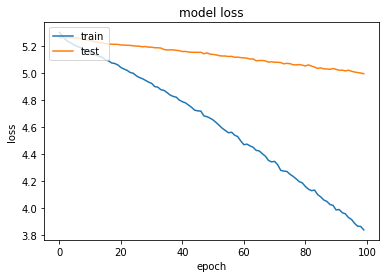

In [70]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model serialisation(Saving the model)
So its time to serialise the model for re-usability. Serialisation and saving mean the same thing. We need to serialise the model architecture and the weights, thats all.

In [71]:
# Save model and weights
model_name = 'kag3_Model2_25pcentval.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json2.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /home/chuka19952/Music/Agric keyword spotter/saved_models/kag3_Model2_25pcentval.h5 


## Model validation
Now predicting emotions on the test data. After serialising the model above, i'm going to just reload it into disk. Essentially to re-use the model without having to retrain by re-running the code, we just need to run this section of the code and apply the model to a new dataset. Since we used the same test set in the keras model, the result is essentially the same as the last epoch of 100 which is 43.80%

In [25]:
# loading json and model architecture 
json_file = open('model_json2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/kag3_Model2_25pcentval.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 2.52%


In [26]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

18/18 [==============================] - 0s 25ms/step


array([ 34,  45,  34,  45,  49, 178,  10,  49,  45,  10, 128,  98,  34,
         6,  49,  45,  34,  34,  45,  49, 159,  34,  98, 128,  49, 132,
        27,  49,  10,  10,  93,  49,  34,  51, 174,  10,  49, 107, 159,
       178,  49,  45,  49,  27, 178, 180,  61, 144, 141,  75,  34,  45,
        80,  27, 178, 178,  49,  10, 180,  80, 128,  49, 107,  10, 159,
        10, 178, 178, 159,  10,  10,  34,  10, 144, 178, 132,  10,  63,
        10,  45,  10, 174,  10,  75,  74, 178,  10,  10,  45,  34,  34,
       174,  49,  49,  10,  45,  49, 159,   5,  49, 174,  51,  10,  34,
        34,   5,  10, 128,  10, 178,  45,  10,  80,  45,  49,  45,  34,
       159,  45, 174,  49, 132,  45,  49, 159,  49, 163,  10,  10,  34,
       178,  49,  10,   5, 144,  45,  10, 159, 178,  45,  34,  49, 163,
        49, 159,  49, 132, 163,  45,  45, 159,  63,  34, 144,  80,  49,
        98, 178, 159, 159, 159, 107,  10,  80, 159,  49, 178, 132, 159,
        45,  10,  10, 132,   4, 178,  53,  34,  34,  49,  75,  3

The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure...

In [27]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,sweet potatoes,akawuka
171,banana,akawuka
172,kisaanyi,ndwadde
173,ekitooke,agriculture
174,pampu,seed
175,worm,ejjobyo
176,fruit picking,ebigimusa
177,ekyeya,ebigimusa
178,ekisaanyi,ebiwuka
179,crop,enkota


## PROCESSING AND PREDICTING THE TEST SET

In [72]:
#HERE we now process our mfccs from the testset audio files and save them in a dataframe dff

dffn = pd.DataFrame(columns=['feature'])

counter=0

for file in sample_sub['fn']:
        
        X, sample_rate = librosa.load(file, sr=44100, duration=2.5, res_type='kaiser_fast')
        sample_rate = np.array(sample_rate)
        
        # mean as the feature. Could do min and max etc as well. 
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
        
        dffn.loc[counter] = [mfccs]
        counter=counter+1   
        

# Check a few records to make sure its processed successfully
print(len(dffn))
dffn.head()

1017


,feature
0,"[-9.950765, -8.805221, -11.02302, -9.525336, -..."
1,"[-42.83981, -42.876278, -42.692635, -42.772118..."
2,"[-29.247925, -29.130037, -35.96887, -41.200073..."
3,"[-44.39936, -44.13117, -44.2246, -44.39936, -4..."
4,"[-44.606525, -44.253525, -47.84052, -47.30944,..."


In [73]:
#just creating an empty dataframe to join with dffn
dffp = pd.DataFrame(columns=['feature2'])

In [74]:
#Now lets extract the each mean band component of the mfccs into their different columns
dffn = pd.concat([dffp,pd.DataFrame(dffn['feature'].values.tolist())],axis=1)
dffn[:5]

,feature2,0,1,2,3,4,5,6,7,8,...,264,265,266,267,268,269,270,271,272,273
0,NaN,-9.950765,-8.805221,-11.023020,-9.525336,-7.716606,-9.867220,-10.130118,-11.085512,-15.589663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-42.839809,-42.876278,-42.692635,-42.772118,-42.801773,-42.707748,-42.652054,-42.677315,-42.670864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-29.247925,-29.130037,-35.968868,-41.200073,-42.793987,-42.996208,-42.417778,-42.881477,-43.411453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-44.399361,-44.131168,-44.224602,-44.399361,-44.399361,-44.399361,-44.398907,-44.375259,-44.346676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-44.606525,-44.253525,-47.840519,-47.309441,-47.018703,-47.141682,-48.021511,-50.285698,-52.090622,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# replace NA with 0
dffn=dffn.fillna(0)
print(dffn.shape)


(1017, 275)


In [76]:
#dropping unneccessary column
dffn  = dffn.drop(['feature2',], axis=1)

In [77]:
# Lets do data normalization 
mean = np.mean(dffn, axis=0)
std = np.std(dffn, axis=0)

dffn = (dffn - mean)/std


# Check the dataset now 
dffn[150:160]

,0,1,2,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,272,273
150,-1.071384,-0.850809,-0.818352,-0.743917,-0.805311,-0.827429,-0.826386,-0.802939,-0.811487,-0.948502,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
151,-0.905766,-0.732326,-0.459556,-0.375626,-0.302344,-0.158305,-0.198390,-0.360791,-0.442451,-0.397978,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
152,-0.090918,-0.209300,-0.609110,-0.581972,-0.593654,-0.626678,-0.649531,-0.635176,-0.630490,-0.624733,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
153,0.180727,0.039824,-0.380046,-0.729241,-0.694436,-0.732143,-0.840852,-0.862907,-0.866429,-0.756819,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
154,1.429385,1.411231,1.400434,1.527096,1.543727,1.454823,1.392725,1.370515,1.337300,1.203559,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
155,1.118786,0.966581,0.636915,0.459880,0.308536,0.196923,0.291715,0.410155,0.422757,0.337374,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
156,1.511829,1.567632,1.813957,1.983595,2.055889,2.267328,2.298635,2.318312,2.313281,2.251240,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
157,0.314739,0.224350,-0.113800,-0.186042,-0.112135,-0.067008,-0.001879,0.036245,-0.006540,0.067029,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
158,1.627179,1.603044,1.641271,1.715012,1.839840,1.835737,1.713540,1.800289,1.884779,1.839062,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373
159,0.053875,0.102245,0.188757,0.200947,-0.024699,-0.094171,-0.068425,-0.091723,-0.070102,-0.165105,...,0.043359,0.04273,0.04219,0.041813,0.041052,0.031373,0.031373,0.031373,0.031373,0.031373


In [78]:
#Adding an extra dimension
dffn = np.array(dffn)
dffn = np.expand_dims(dffn, axis=2)

## LOADING MODEL, PREDICTING AND PREPARING SUBMISSION FILE

In [79]:
#loading model and predicting with  the model
model= tf.keras.models.load_model('saved_models/kag3_Model2_25pcentval.h5')

In [92]:
# #predicting the test set proper
ssd = model.predict(dffn)

In [ ]:
#copying sample_sub into a new variable
samp = sample_sub.copy()

#obtaining column list
wwe=samp.columns

#eliminating the fn column
wwe = wwe[1:]

# creating the dataframe 
df3 = pd.DataFrame(data = ssd,  
                  index = None,  
                  columns = wwe) 

#Adding back the fn column to submission file but first assigning it to a variable
tio = sample_sub['fn']

#now we combine all datasets together
cbd =pd.concat([tio,df3], axis=1)

cbd.to_csv('Sub10.csv', index=False)

## OBSERVATIONS

1. After 100 epochs, categorical_crossentropy, lr = 0.0001, batch_size = 16, optimizer = rmsprop : results as follows val_loss = 5.03, loss = 4.4

2. 